In [6]:
import torch
import numpy as np
import scipy
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage import io, transform
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import decomposition
from sklearn import svm
from matplotlib import cm
import torch.nn.functional as F
from torch import nn
import math
import pandas as pd
import os
import shapedimutils as s

%matplotlib inline

root = '/mnt/neurosphere/serenceslab2/maggie/shapeDim/'

image_dir = os.path.join(root,'Stimuli','AmpGrid3_adj_full_grey_small')
save_activ_dir = os.path.join(root,'Modeling','network_activs')
if not os.path.exists(save_activ_dir):
    os.makedirs(save_activ_dir)
    
csv_file = os.path.join(image_dir, 'shape_labels_all.csv')
shape_labels = pd.read_csv(csv_file)

[0 1 1]
(3,)


([], [])

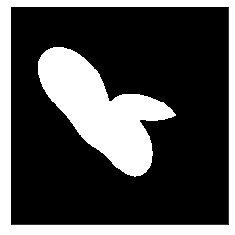

In [4]:
# testing out dataset generation for example items
# create an object of shape_dataset class
sds = s.shape_dataset(csv_file, image_dir)

# pull out one item by indexing (at this point the image file actually gets loaded)
item = sds[1000]
print(item['task_labels'])
print(np.shape(item['task_labels']))
plt.figure();
# plot the shape image
plt.pcolormesh(np.flipud(item['image'][:,:,0]),cmap='gray') # flip so y axis is correct
plt.axis('square')
plt.xticks([])
plt.yticks([])

In [2]:
# run the model to get activations and save...
a = s.get_alexnet_activations(image_dir)
s.save_pca_activ(a, save_activ_dir)

getting activs for batch 0 of 27
getting activs for batch 1 of 27
getting activs for batch 2 of 27
getting activs for batch 3 of 27
getting activs for batch 4 of 27
getting activs for batch 5 of 27
getting activs for batch 6 of 27
getting activs for batch 7 of 27
getting activs for batch 8 of 27
getting activs for batch 9 of 27
getting activs for batch 10 of 27
getting activs for batch 11 of 27
getting activs for batch 12 of 27
getting activs for batch 13 of 27
getting activs for batch 14 of 27
getting activs for batch 15 of 27
getting activs for batch 16 of 27
getting activs for batch 17 of 27
getting activs for batch 18 of 27
getting activs for batch 19 of 27
getting activs for batch 20 of 27
getting activs for batch 21 of 27
getting activs for batch 22 of 27
getting activs for batch 23 of 27
getting activs for batch 24 of 27
getting activs for batch 25 of 27
getting activs for batch 26 of 27
running pca (original size 2601 by 193600)
finished
saving to /mnt/neurosphere/serenceslab2/

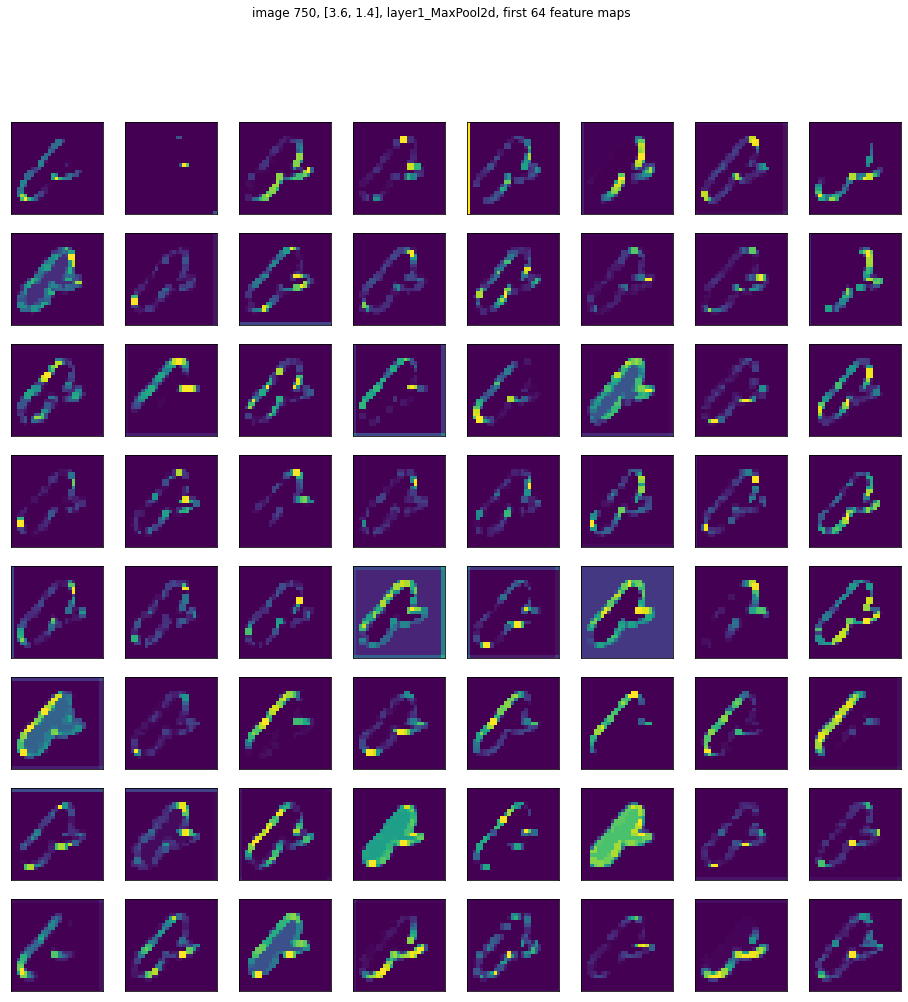

In [8]:
# visualize some feature map activations for an example image

# load full activations for an entire layer, all units all images 
layer2plot = 2
layer_names = ['1_Conv2d','1_ReLU','1_MaxPool2d',
                   '2_Conv2d','2_ReLU','2_MaxPool2d',
                   '3_Conv2d','3_ReLU',
                   '4_Conv2d','4_ReLU',
                   '5_Conv2d','5_ReLU','5_MaxPool2d']
fn2load = os.path.join(save_activ_dir, 'AlexNet_%s_fullactiv.npy'%layer_names[layer2plot])
activ= np.load(fn2load)
np.shape(activ)
# shape is [nims x nchannels x h x w]

plt.figure(figsize=(16,16))

# how many channels to plot?
nchan2plot=64; #first layer has 64 chans
# which image to plot?
im2plot=750; # images 0-2601

npx = int(np.ceil(np.sqrt(nchan2plot)))
npy = int(np.ceil(nchan2plot/npx))
for cc in range(nchan2plot):
    plt.subplot(npx, npy,cc+1)
    plt.pcolormesh(activ[im2plot,cc,:,:])
    plt.axis('square')
    plt.xticks([]);
    plt.yticks([]);
plt.suptitle('image %d, [%.1f, %.1f], layer%s, first %d feature maps'%(im2plot, 
                                                              shape_labels['coord_axis1'][im2plot],
                                                              shape_labels['coord_axis2'][im2plot],
                                                              layer_names[layer2plot],
                                                              nchan2plot));

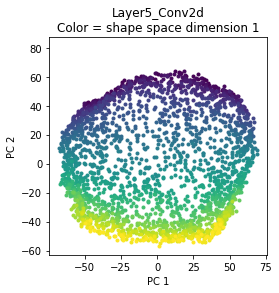

In [9]:
layer2plot = 10
fn2load = os.path.join(save_activ_dir, 'AlexNet_%s_pca.npy'%layer_names[layer2plot])
pc = torch.load(fn2load)
scores = pc['scores']
# plot the images in PC space
# Color by dimension 1 in shape space
viridis = cm.get_cmap('viridis')
grid_x = np.unique(shape_labels['coord_axis1'])

cols2plot = viridis(np.linspace(0,1,len(grid_x)))
plt.figure();
for ii in range(len(grid_x)):
  inds2plot = np.where(shape_labels['coord_axis1']==grid_x[ii])[0]
  plt.plot(scores[inds2plot,0],scores[inds2plot,1],'.',color=cols2plot[ii,:])

plt.axis('square');
# plt.xticks([]);
# plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Layer%s\nColor = shape space dimension 1'%layer_names[layer2plot]);

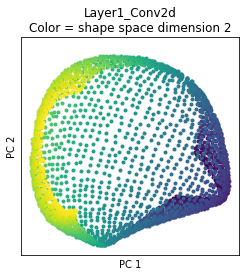

In [10]:
layer2plot = 0
fn2load = os.path.join(save_activ_dir, 'AlexNet_%s_pca.npy'%layer_names[layer2plot])
pc = torch.load(fn2load)
scores = pc['scores']
# plot the images in PC space
# Color by dimension 2 in shape space
viridis = cm.get_cmap('viridis')

grid_y = np.unique(shape_labels['coord_axis2'])
cols2plot = viridis(np.linspace(0,1,len(grid_y)))
plt.figure();
for ii in range(len(grid_y)):
  inds2plot = np.where(shape_labels['coord_axis2']==grid_y[ii])[0]
  plt.plot(scores[inds2plot,0],scores[inds2plot,1],'.',color=cols2plot[ii,:])

plt.axis('square');
plt.xticks([]);
plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Layer%s\nColor = shape space dimension 2'%layer_names[layer2plot]);

In [11]:
# doing PCA across just the "main grid" of 16 images
layer2plot = 6
fn2load = os.path.join(save_activ_dir, 'AlexNet_%s_fullactiv.npy'%layer_names[layer2plot])
print('loading activ from %s'%fn2load)
activ = np.load(fn2load)
print('loaded')
csv_file = os.path.join(image_dir, 'shape_labels_all.csv') 
print('loading image labels from %s'%csv_file)
shape_labels = pd.read_csv(csv_file)
print('loaded')

# taking out just 16 main grid images
main_grid = np.round(np.linspace(0.1, 4.9, 4))
ims2do = np.isin(shape_labels['coord_axis1'], main_grid) & np.isin(shape_labels['coord_axis2'], main_grid)
activ = activ[ims2do,:]
# first, reshape to [nIms x nUnits]
# disregarding difference between channels/spatial dims for now
nUnitsTotal = np.prod(np.shape(activ)[1:])
nIms = np.shape(activ)[0]
activ_full = np.reshape(activ,[nIms, nUnitsTotal])
np.shape(activ_full)

# reduce dimensionality of whole matrix w PCA
pca = decomposition.PCA()
print('running pca (original size %d by %d)'%(np.shape(activ_full)[0], np.shape(activ_full)[1]))
pca.fit(activ_full)
scores = pca.transform(activ_full)
print('finished')

loading activ from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Modeling/network_activs/AlexNet_3_Conv2d_fullactiv.npy
loaded
loading image labels from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/shape_labels_all.csv
loaded
running pca (original size 16 by 64896)
finished


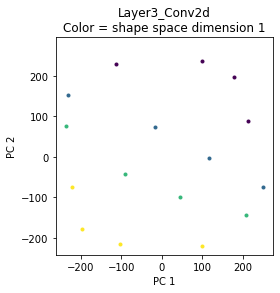

In [12]:
# plot the images in PC space
# Color by dimension 1 in shape space
viridis = cm.get_cmap('viridis')
grid_x = main_grid

cols2plot = viridis(np.linspace(0,1,len(grid_x)))
plt.figure();
for ii in range(len(grid_x)):
  inds2plot = np.where(shape_labels['coord_axis1'][ims2do]==grid_x[ii])[0]
  plt.plot(scores[inds2plot,0],scores[inds2plot,1],'.',color=cols2plot[ii,:])

plt.axis('square');
# plt.xticks([]);
# plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Layer%s\nColor = shape space dimension 1'%layer_names[layer2plot]);